In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal
from scipy import stats

from sonar import sonar, utils
import math

In [3]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = [
    'background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [4]:
relevant_cluster_labels =  [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan'
]

In [5]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'

In [6]:
plt.figure(figsize=[10,10])

n_sample = 1

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

<Figure size 1000x1000 with 0 Axes>

In [7]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

In [48]:
rescaled.shape

(16, 1788, 2343)

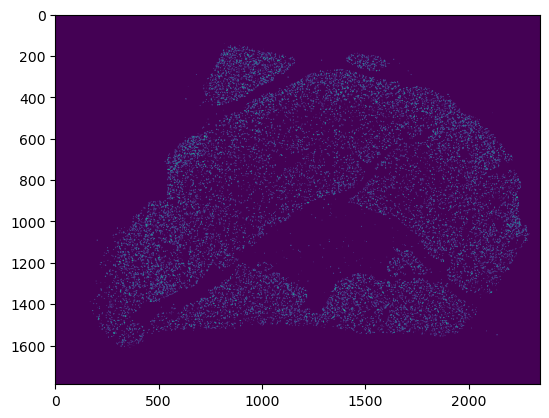

In [50]:
plt.imshow(rescaled[1])

In [8]:
# calculation of the tissue area of each cell-type
def total_pixel_counts(original_img = rescaled, cell_type_labels = relevant_cluster_labels):

    # fig, ax = plt.figure(figsize=[10,3])

    tissue_pixels = []
    for i in range(len(cell_type_labels)):
        pix_agreg = np.sum(rescaled[i+1]) # rescaled[i+1] because under 0 here is a background
        tissue_pixels.append(pix_agreg)
        # print(pix_agreg)

    # ax.bar(cell_type_labels,tissue_pixels)
    # ax.set_xticks(rotation=45, ha="right")

    # plt.show()

    return list(tissue_pixels)

pixel_counts = total_pixel_counts(rescaled)

In [45]:
pixel_counts

[76427.0,
 696597.0,
 4112.0,
 3774.0,
 4405.0,
 2195.0,
 7873.0,
 547.0,
 249.0,
 56161.0,
 8143.0,
 1017.0,
 222.0]

In [44]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=False, circumference_normalization=False)
cooc_template_ = son.co_occurrence_from_tensor(rescaled[1:],interpolate=False, area_normalization = False) 

In [51]:
cooc_template_.shape

(15, 15, 500)

(0.0, 5000000.0)

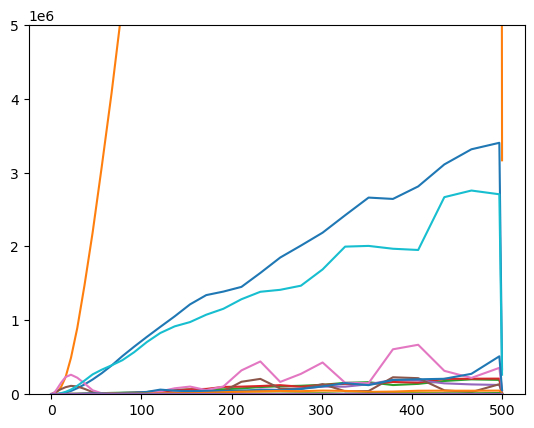

In [55]:
plt.plot(cooc_template_[0],cooc_template_[1][5,].T)
plt.ylim(0,5000000)


#  the raw sonar pulse

In [56]:
son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=True, circumference_normalization=True)
cooc_template_ = son.co_occurrence_from_tensor(rescaled[1:],interpolate=False, area_normalization = False) 

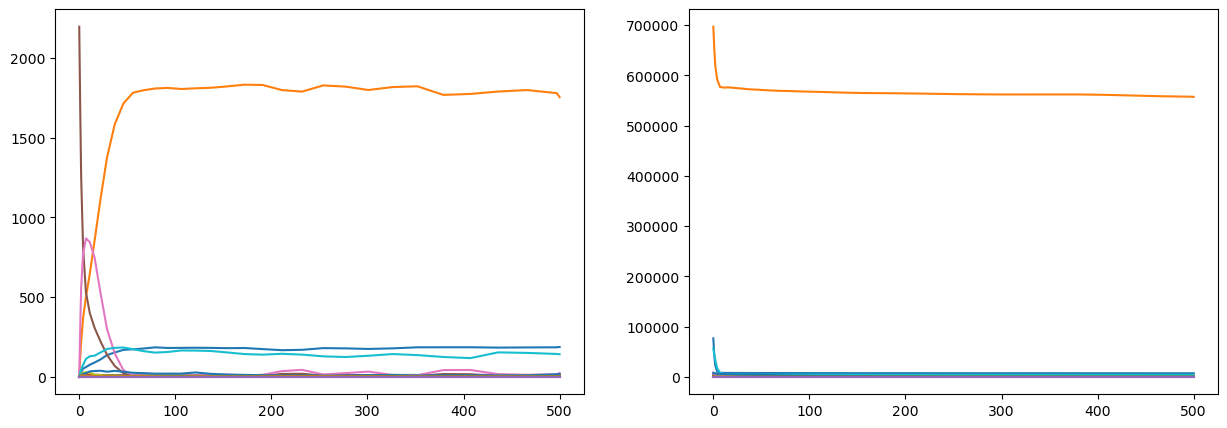

In [58]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(cooc_template_[0],cooc_template_[1][5,].T)

plt.subplot(122)
plt.plot(cooc_template_[0],cooc_template_[1].diagonal())

# circumference normalization

In [61]:
son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=False, normalize=True)
radii, cooc_template_ = son.co_occurrence_from_tensor(rescaled[1:],interpolate=False, area_normalization = True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:209: RuntimeWarning: invalid value encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])


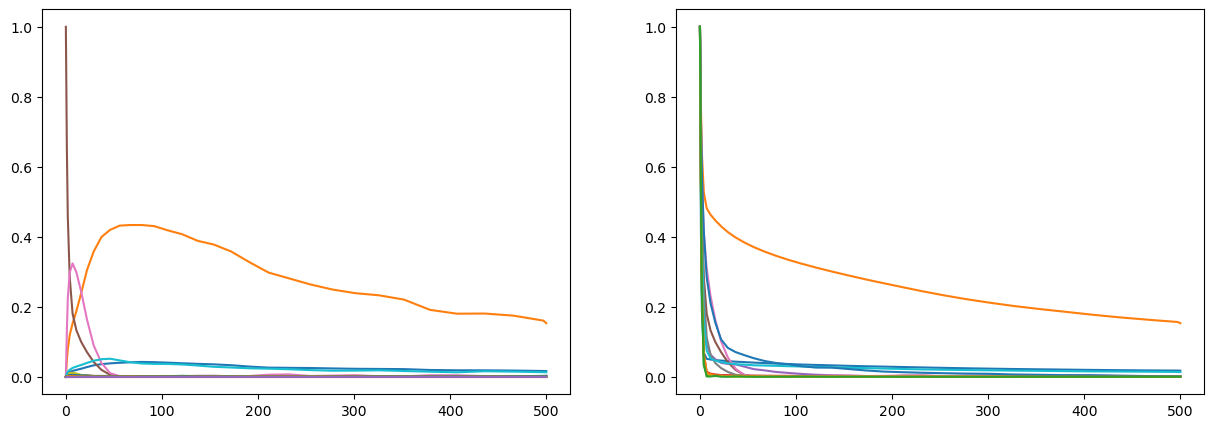

In [62]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(radii, cooc_template_[5,].T)

plt.subplot(122)
plt.plot(radii, cooc_template_.diagonal())

In [59]:
son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=True, circumference_normalization=True)
radii, cooc_template_ = son.co_occurrence_from_tensor(rescaled[1:],interpolate=False, area_normalization = True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:209: RuntimeWarning: invalid value encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])


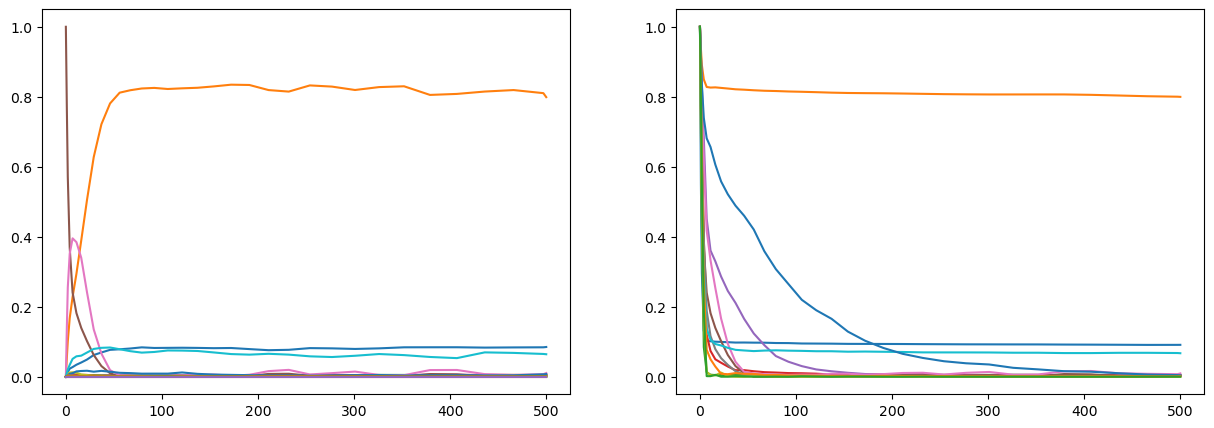

In [60]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(radii, cooc_template_[5,].T)

plt.subplot(122)
plt.plot(radii, cooc_template_.diagonal())

# normalization to 1 


# (describing size of features )

In [64]:
son = sonar.Sonar(max_radius=rad_,linear_steps=lin, edge_correction=True, circumference_normalization=True)
cooc_template_ = son.co_occurrence_from_tensor(rescaled[1:],interpolate=False, area_normalization = False) 

radii, cooc_template_ = cooc_template_

# Normalisation to the number of pixels of cell-types in the tissue

def normalize_co_occurrence_matrix(matrix = cooc_template_, cell_counts = pixel_counts):
    n, _, m = matrix.shape
    normalized_matrix = np.zeros_like(matrix)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_matrix[i, j, k] = matrix[i, j, k] / (cell_counts[i] * cell_counts[j])
    
    return normalized_matrix


normalized_matrix = normalize_co_occurrence_matrix(cooc_template_[:13])

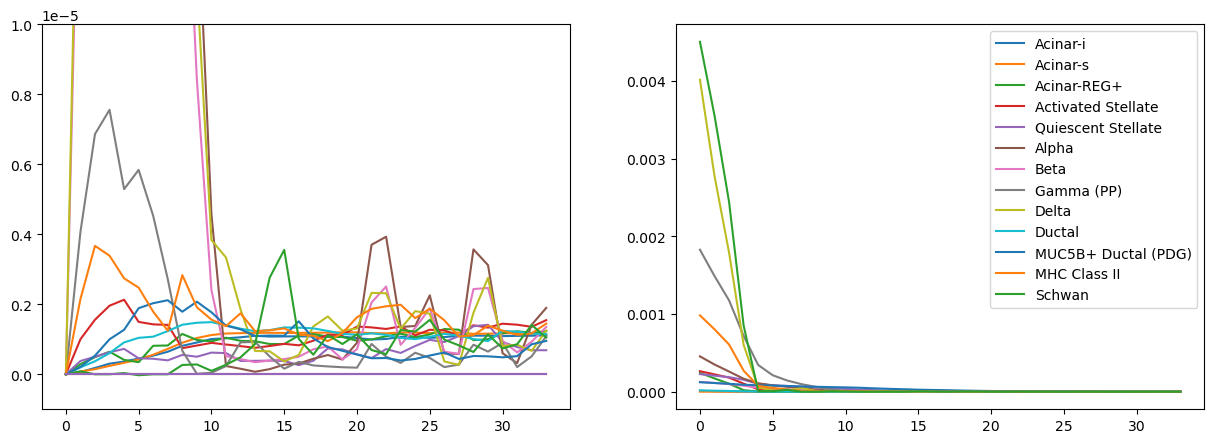

In [65]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(normalized_matrix[5,].T)
plt.ylim(-0.000001, 0.00001)

plt.subplot(122)
plt.plot(normalized_matrix.diagonal(), label = relevant_cluster_labels)

# plt.ylim(-0.000001, 0.00002)

plt.legend()

In [72]:
def normalize_co_occurrence_matrix(matrix = cooc_template_, cell_counts = pixel_counts):
    n, _, m = matrix.shape
    normalized_matrix = np.zeros_like(matrix)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_matrix[i, j, k] = matrix[i, j, k] / cell_counts[j]
    
    return normalized_matrix


normalized_matrix = normalize_co_occurrence_matrix(cooc_template_[:13])

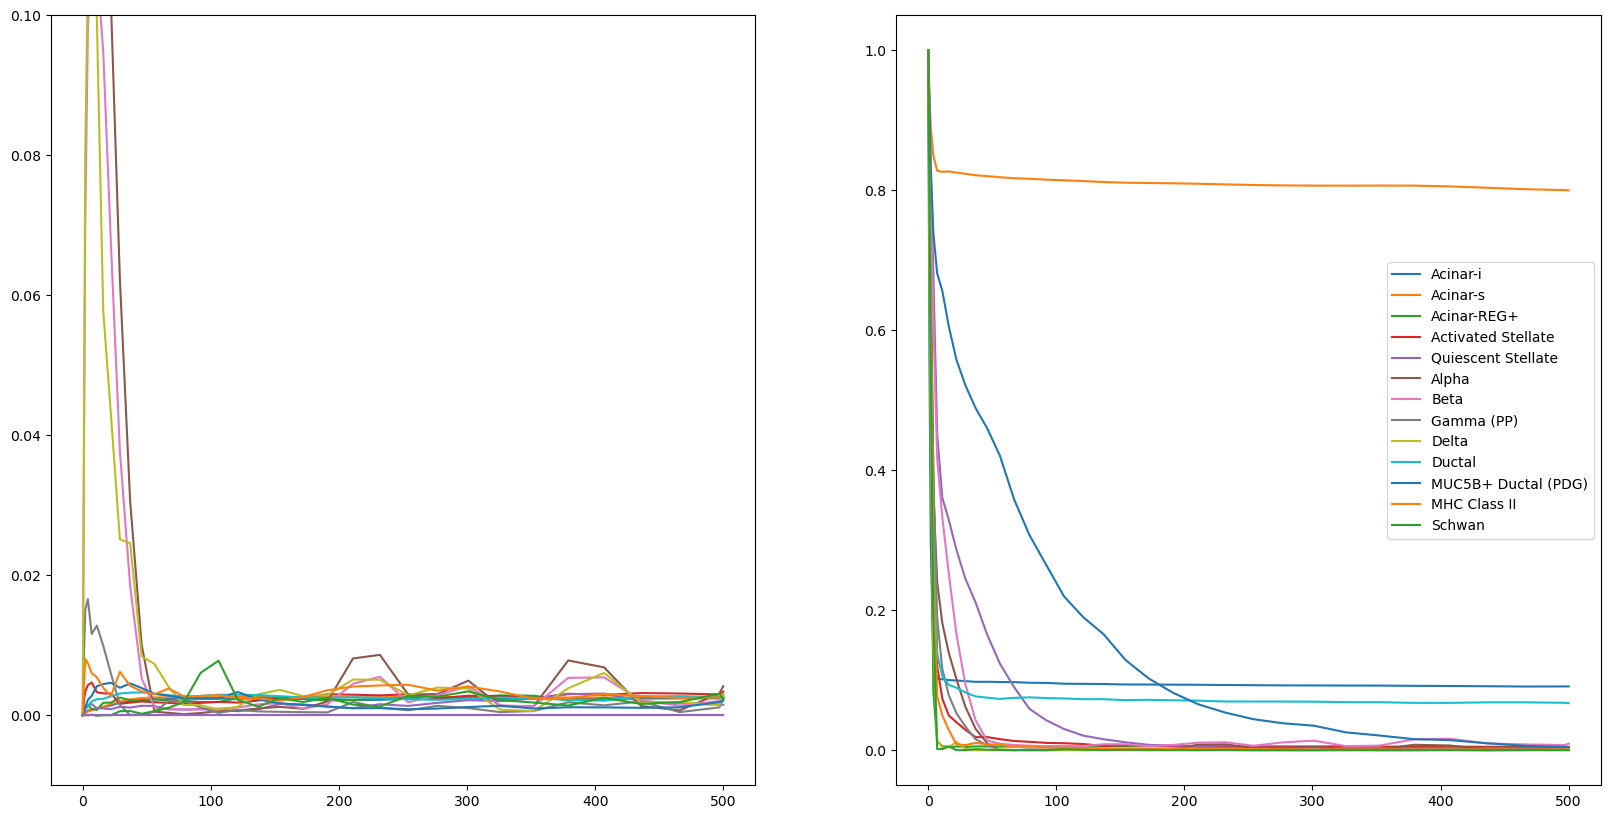

In [79]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.plot(radii, normalized_matrix[5,].T)
# plt.yscale("log")
plt.ylim(-0.01, 0.1)

plt.subplot(122)
plt.plot(radii, normalized_matrix.diagonal(), label = relevant_cluster_labels)

# plt.ylim(-0.000001, 0.00002)

plt.legend()

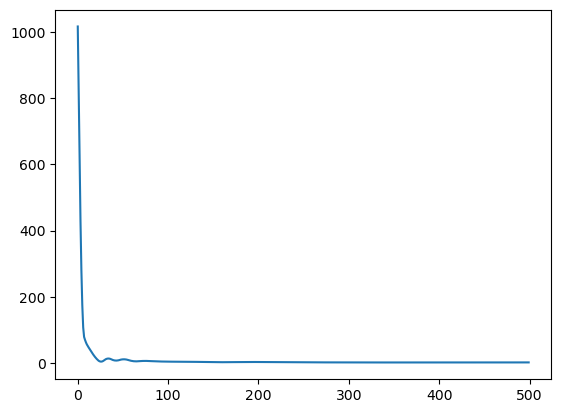

In [37]:
plt.plot(cooc_template_[11,11])
# plt.ylim(-0.1, 1)

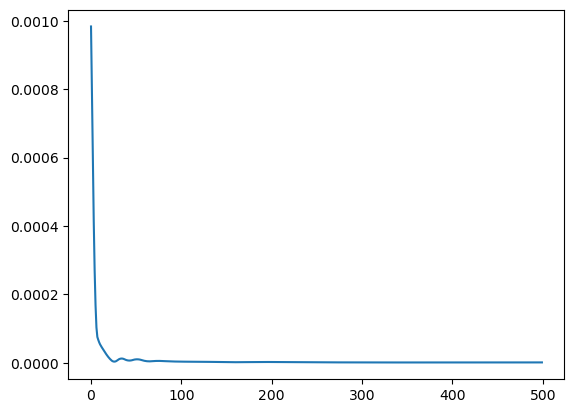

In [38]:
plt.plot(normalized_matrix[11,11])

In [278]:
# plt.imshow(rescaled[6]) # alpha cells

## 1) Simple plot

In [33]:
def simple_cooc_plot(cooc_curves_res, cell_type = "all", cell_type_labels = relevant_cluster_labels, um_per_px=1.0):#, y_zoom = 0.1): #cell_type_labels should be changed
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int or 'all'. 'all' by default to plot all cell types. Can be customized by choosing spesific cell-type number.
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
    # ax.set_ylim(-0.025, y_zoom)
    ax.set_ylim(-0.000001,0.0001)

    # X = 
    # Y = 

    if cell_type == "all":
        for i in range(13): 
            Y = cooc_curves_res[i,i]
            ax.plot(np.arange(len(Y))*um_per_px, Y)
        ax.legend(cell_type_labels, loc="upper right", bbox_to_anchor=(1.45, 1)) # specific case for pancreas, needs to be more general
        ax.set_title(f"Auto-co-occurrence of all cell types")
    else:
        Y = cooc_curves_res[cell_type,cell_type]
        ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])
        ax.legend(loc="upper right")
        ax.set_title(f"Auto-co-occurrence of {cell_type_labels[cell_type]} cell-type")


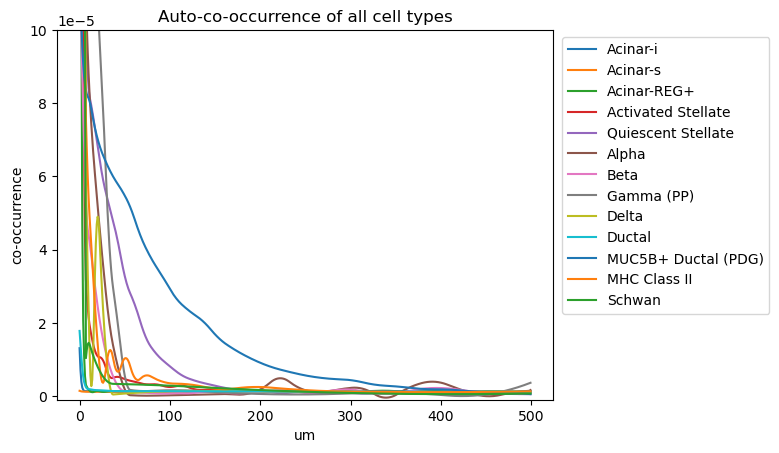

In [34]:
simple_cooc_plot(cooc_curves_res = normalized_matrix, cell_type_labels = relevant_cluster_labels)#,  y_zoom = 0.1)

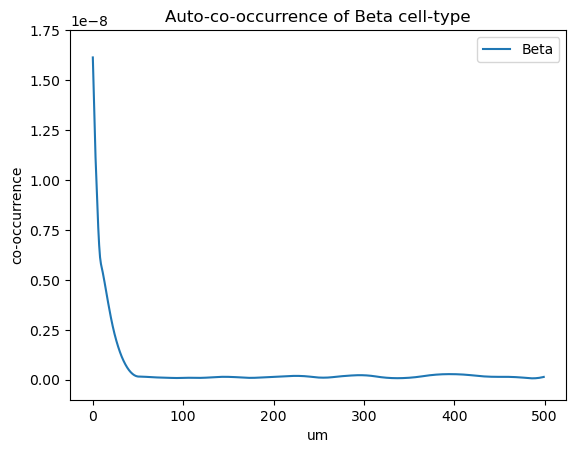

In [51]:
simple_cooc_plot(cooc_curves_res = normalized_matrix, cell_type_labels = relevant_cluster_labels, cell_type =6 )#, y_zoom = 0.001)

(-1e-07, 1e-05)

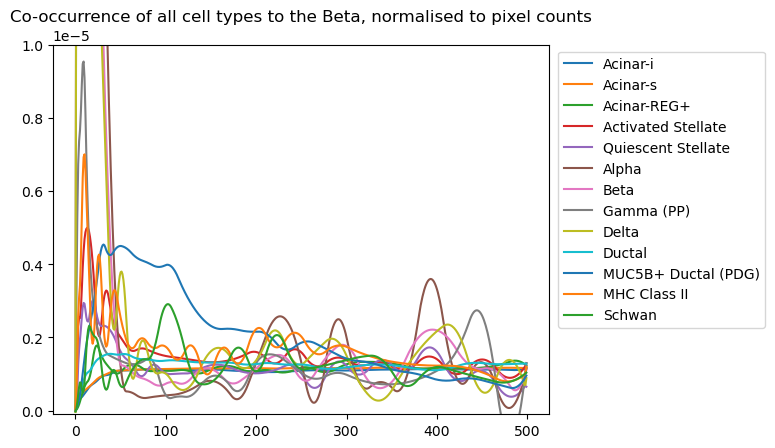

In [37]:
selected_cell_type = 6
for i in range(13):
    plt.plot(normalized_matrix[selected_cell_type, i])

plt.legend(relevant_cluster_labels, loc="upper right", bbox_to_anchor=(1.45, 1)) # specific case for pancreas, needs to be more general
plt.title(f"Co-occurrence of all cell types to the {relevant_cluster_labels[selected_cell_type]}, normalised to pixel counts")
plt.ylim(-0.0000001, 0.00001)

Text(0.5, 1.0, 'Co-occurrence of all cell types to the Beta, non-normalised to pixel counts')

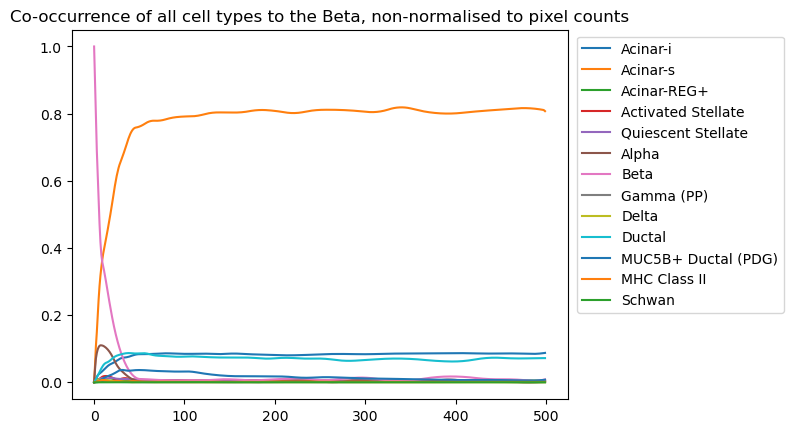

In [14]:
selected_cell_type = 6
for i in range(13):
    plt.plot(cooc_template_[selected_cell_type, i])

plt.legend(relevant_cluster_labels, loc="upper right", bbox_to_anchor=(1.45, 1)) # specific case for pancreas, needs to be more general
plt.title(f"Co-occurrence of all cell types to the {relevant_cluster_labels[selected_cell_type]}, non-normalised to pixel counts")
# plt.ylim(-0.0000000001, 0.000000001)

Text(0.5, 1.0, 'Auto-co-occurrence of Gamma (PP) cell-type')

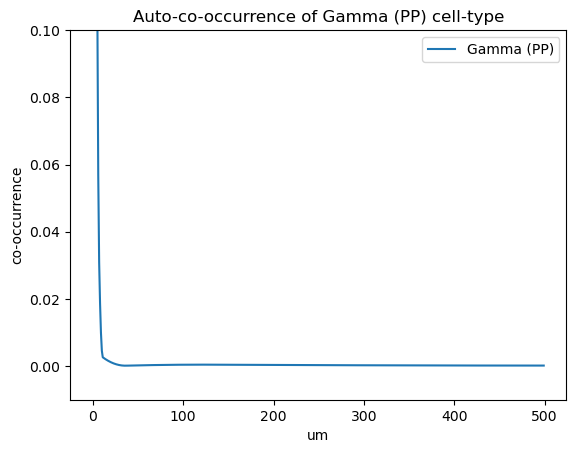

In [274]:
um_per_px = 1
Y = cooc_template_[7,7]

fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um")
ax.set_ylim(-0.01, 0.1)

ax.plot(np.arange(len(Y))*um_per_px, Y, label=relevant_cluster_labels[7])
ax.legend(loc="upper right")
ax.set_title(f"Auto-co-occurrence of {relevant_cluster_labels[7]} cell-type")

## 2) Co-occurrence with computed radii

In [126]:
def cooc_with_computed_radii(cooc_curves_res, cell_type, radii, cell_type_labels = relevant_cluster_labels, um_per_px = 1.0, y_zoom = 0.1): #cell_type_labels should be changed
    
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int, selected cell-type number.
    - rad_: int, selected radii
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um")
    ax.set_ylim(-0.01, y_zoom)

    Y = cooc_curves_res[cell_type,cell_type]

    ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])
    ax.legend(loc="upper right")
    ax.set_title(f"Auto-co-occurrence of {cell_type_labels[cell_type]} cell-type with computed radii")

    # plot radii
    for rad_ in list(range(radii,500,radii)):
        ax.axvline(rad_, linewidth=0.5, color='orange')


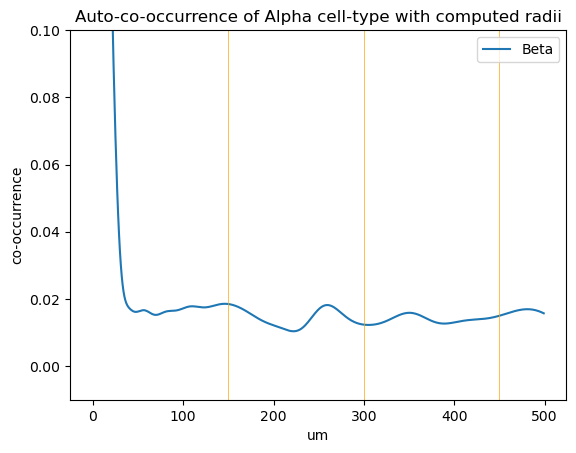

In [127]:
cooc_with_computed_radii(cooc_curves_res=cooc_template_, cell_type=6, radii=150)

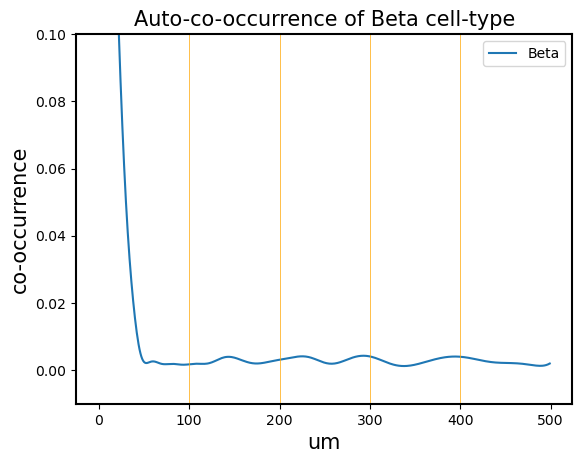

In [439]:
fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um")
ax.set_ylim(-0.01, 0.1)

ax.plot(cooc_template_[int(7),int(7)], label=cluster_labels[int(7)])
ax.legend(loc="upper right")
ax.set_title(f"Auto-co-occurrence of {cluster_labels[7]} cell-type")


for i in list(range(100,500,100)):
    ax.axvline(i, linewidth=0.5, color='orange')

## 3) Curve with error margins:

In [588]:
def cooc_with_error_margins(cooc_curves_res, cell_type, error_margin, cell_type_labels = relevant_cluster_labels, um_per_px=1.0, y_zoom = 0.1): #cell_type_labels should be changed
    
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int, selected cell-type number.
    - error_margin: float, passed error margin value
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter. 
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
    ax.set_ylim(-0.01, y_zoom)

    Y = cooc_curves_res[cell_type,cell_type]
    X = np.arange(len(Y))*um_per_px # x axis of the plot

    # plots preparation
    initial_plot = Y
    min_error = Y-error_margin
    max_error = Y+error_margin

    # ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])

    # margin error plotting
    ax.plot(X, initial_plot, label=cell_type_labels[cell_type], color = 'b')
    ax.plot(X, min_error, color = 'orange', linewidth = 0.001)
    ax.plot(X, max_error, color = 'orange', linewidth = 0.001)
    ax.fill_between(x=X, y1=min_error, y2=max_error, color = 'orange', alpha = 0.5)

    ax.legend(loc="upper right")
    ax.set_title(f"Auto-co-occurrence of {cluster_labels[7]} cell-type with margin errors")

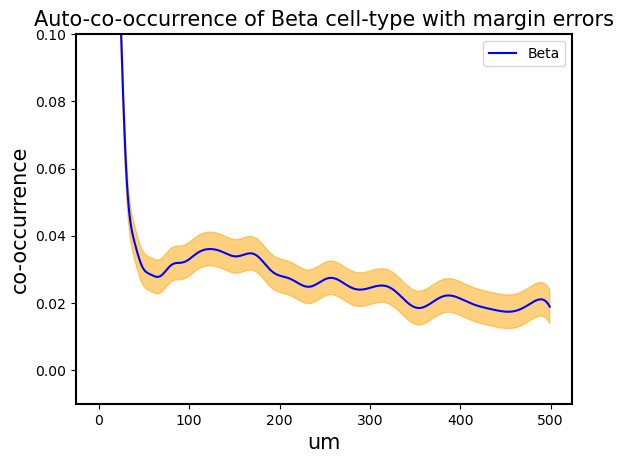

In [589]:
cooc_with_error_margins(cooc_curves_res=cooc_template_, cell_type=6, error_margin=0.005)

Text(0.5, 1.0, 'Auto-co-occurrence of Beta cell-type with margin errors')

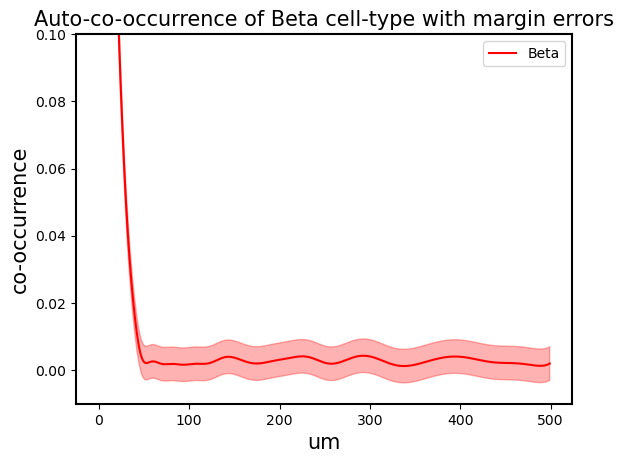

In [442]:
# trial for the previour function
fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um")
ax.set_ylim(-0.01, 0.1)

initial_plot = cooc_template_[int(7),int(7)]
min_error = cooc_template_[int(7),int(7)]-0.005
max_error = cooc_template_[int(7),int(7)]+0.005

X = list(range(cooc_template_.shape[2]))

ax.plot(initial_plot, label=cluster_labels[7], color = 'r')
ax.plot(min_error, color = 'r', linewidth = 0.001)
ax.plot(max_error, color = 'r', linewidth = 0.001)
ax.fill_between(x=X, y1=min_error, y2=max_error, color = 'r', alpha = 0.3)

ax.legend(loc="upper right")
ax.set_title(f"Auto-co-occurrence of {cluster_labels[7]} cell-type with margin errors")

## 4) Plot with significance indicatior

In [590]:
# creation of a training set for the future function
# irrelevant for other scales and different um/px
"""Task: to develop a proper function for selection of the significant areas in the array
"""
zer_ar = np.zeros(500)
zer_ar[0:60] = 1
zer_ar[190:250] = 1
zer_ar[280:330] = 1
zer_ar[360:420] = 1

bool_ar = zer_ar.astype(bool)

In [591]:
def significance_ident(cooc_curves_res, cell_type, bool_array, 
                       cell_type_labels = relevant_cluster_labels, um_per_px=1, y_zoom = 1.0): #cell_type_labels should be changed
    """
    Indicates 'significant' areas of the co-occurrence plot 
    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int number, selected cell type.
    - bool_array: boolean array indicating distances of 'significance'.
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """

    # preprocessing of the boolean array to recieve edges of highlighted areas
    dist_list = []
    for pos, value in enumerate(bool_ar):
        if value != bool_ar[pos-1]:
            dist_list.append(pos)

    # plotting of the significant areas
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um")
    ax.set_title(f"Significance indication plot of {cell_type_labels[cell_type]} cell-type auto-co-occurrence")

    Y = cooc_template_[cell_type,cell_type]
    X = np.arange(len(Y))*um_per_px

    ax.plot(X, Y)
    ax.set_ylim(-0.001,y_zoom)

    for i in range(0,len(dist_list),2):

        ax.axvspan(dist_list[i], dist_list[i+1], alpha = 0.3, color = "orange")
    

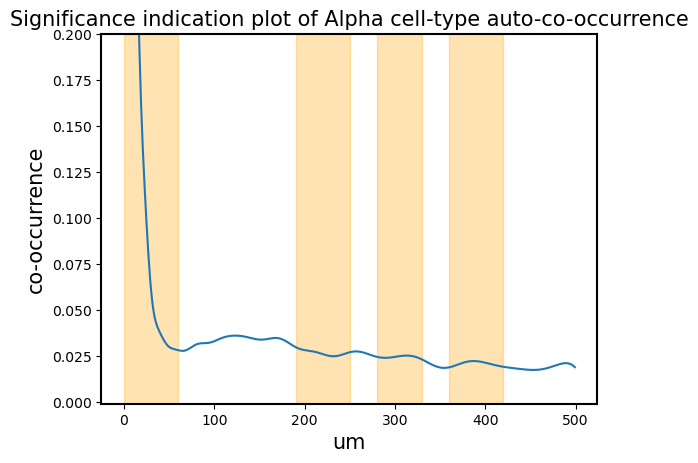

In [593]:
significance_ident(cooc_curves_res = cooc_template_, cell_type=6, bool_array=bool_ar, 
                       cell_type_labels = cluster_labels, y_zoom=0.2)

## 5) stacked local distributions

In [10]:
# calculation of the tissue area of each cell-type
def total_pixel_counts(original_img = rescaled, cell_type_labels = relevant_cluster_labels):

    # fig, ax = plt.figure(figsize=[10,3])

    tissue_pixels = []
    for i in range(len(cell_type_labels)):
        pix_agreg = np.sum(rescaled[i+1]) # rescaled[i+1] because under 0 here is a background
        tissue_pixels.append(pix_agreg)
        # print(pix_agreg)

    # ax.bar(cell_type_labels,tissue_pixels)
    # ax.set_xticks(rotation=45, ha="right")

    # plt.show()

    return list(tissue_pixels)

In [11]:
tissue_pixel_ = total_pixel_counts(original_img = rescaled)

In [12]:
print(tissue_pixel_)

[97550.0, 984839.0, 14495.0, 4537.0, 2790.0, 7951.0, 20647.0, 1322.0, 10936.0, 32367.0, 2125.0, 7883.0, 2347.0]


In [13]:
""" Tasks:
- to add expected values on the right hand side of the plot
- change color palette? SO that there are no repetitions
- also maybe the location and the order of the legend needs to be changed. 
So that it reflrcts the order of cell-types and also can possibly start from the bottom right conner

"""

def stacked_local_distrib(cooc_curves_res, cell_type, normal_array=None, cell_type_labels = relevant_cluster_labels, um_per_px = 1.0):
                    #cell_type_labels should be changed
    """
    Plots stacked co-occurrence plots which shows their distribution over different distances
    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int number, selected cell type.
    - normal_array, (list, array): sum of pixels that compose cell-types, the result of total_pixel_counts()
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - show_bg: bool, True by default. Shows the distribution of the background.
    Returns:
    
    """

    # if normalisation array is not provided
    if normal_array == None:
        normal_array = np.ones(cooc_template_.shape[0])


    ct_list = list(range(0,13))
    cell_type_sum = np.zeros(500)
        
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
    ax.set_title(f"Stacked local distribution of {cell_type_labels[cell_type]} cell-type VS other cell-types")
    ax.set_ylim(-0.000001, 0.00003)

    # plotting of other cell-types
    for i in ct_list:
        Y = cooc_curves_res[cell_type,i]/normal_array[i]
        X = np.arange(len(Y))*um_per_px
        prev = cell_type_sum.copy()
        cell_type_sum += Y
        ax.fill_between(X,cell_type_sum,prev, alpha = 0.5)
        ax.plot(X , cell_type_sum, label=cell_type_labels[i], linewidth=0.5)

    # get the legend object
    leg = ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(4.0)

    # plt.show()

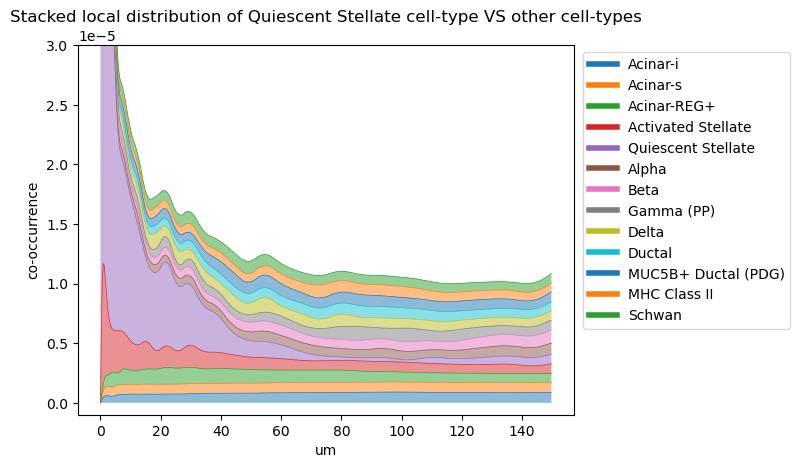

In [15]:
stacked_local_distrib(cooc_template_, 4, normal_array=tissue_pixel_, um_per_px=0.3)
# stacked_local_distrib(cooc_template_, 6)

In [ ]:
print(tissue_pixel_[6])
plt.imshow(rescaled[7])

Sample 4. Local distribution of Alpha cells

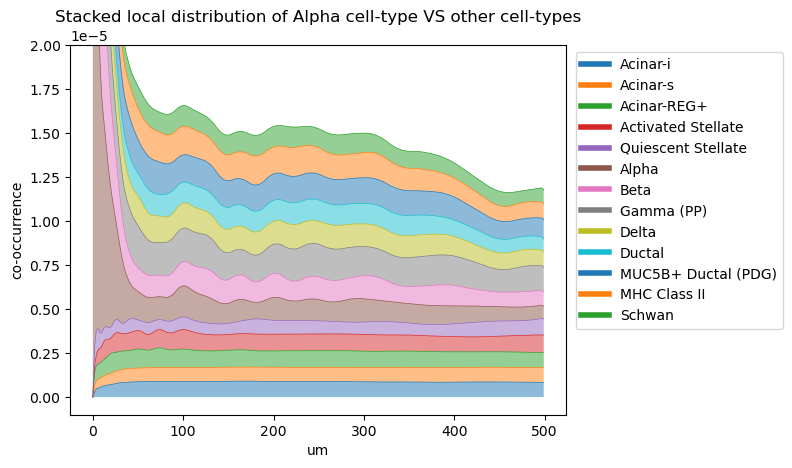

In [351]:
stacked_local_distrib(cooc_template_, 5, normal_array=tissue_pixel_)
# stacked_local_distrib(cooc_template_, 6)

20647.0


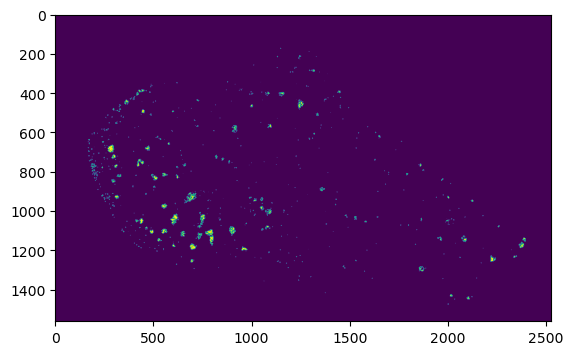

In [353]:
print(tissue_pixel_[6])
plt.imshow(rescaled[7])

Sample 3. Local distribution of Activated Stellate cells

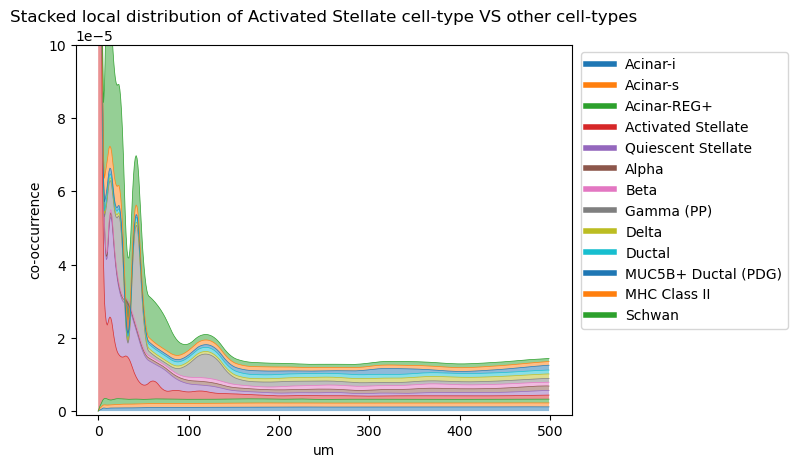

In [319]:
stacked_local_distrib(cooc_template_, 3, normal_array=tissue_pixel_)
# stacked_local_distrib(cooc_template_, 6)

In [ ]:
print(tissue_pixel_[6])
plt.imshow(rescaled[7])

Sample 3. Local distribution of Gamma PP cells

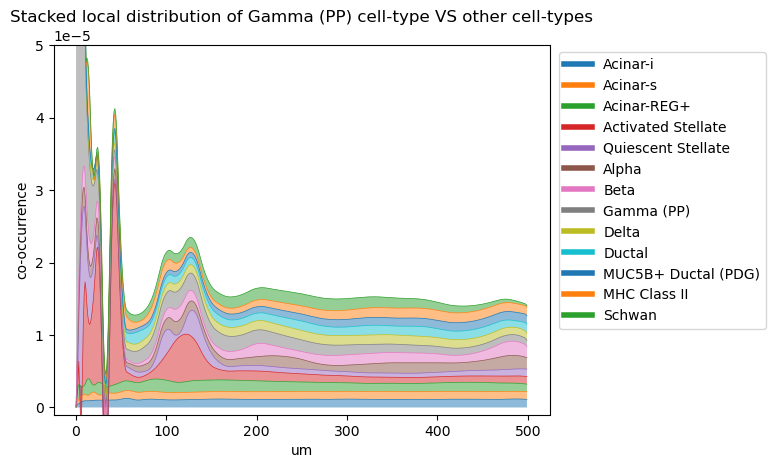

In [307]:
stacked_local_distrib(cooc_template_, 7, normal_array=tissue_pixel_)
# stacked_local_distrib(cooc_template_, 6)

16569.0


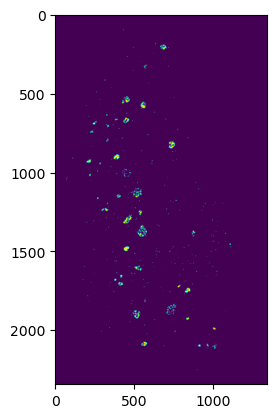

In [302]:
print(tissue_pixel_[6])
plt.imshow(rescaled[7])

Sample 2, Alpha cells co-occurrence. 
The signal from islets is not very strong. Possibly, due to more "randon"distribution of islets in the sample (see down below the img of the sample's alpha cells)

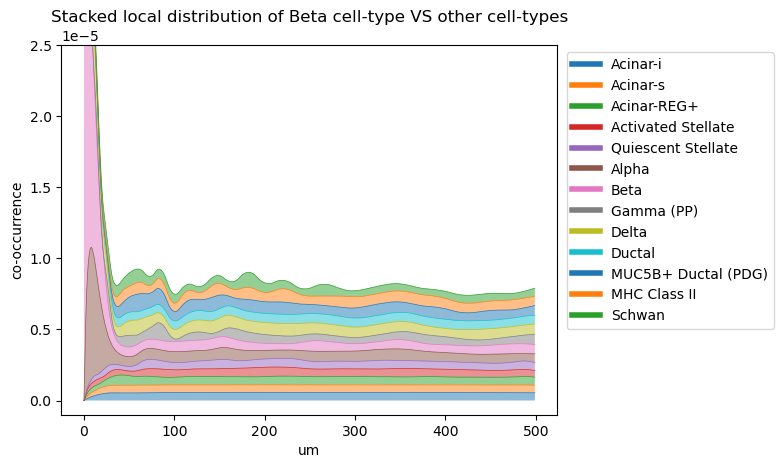

In [290]:
stacked_local_distrib(cooc_template_, 6, normal_array=tissue_pixel_)
# stacked_local_distrib(cooc_template_, 6)

131.0


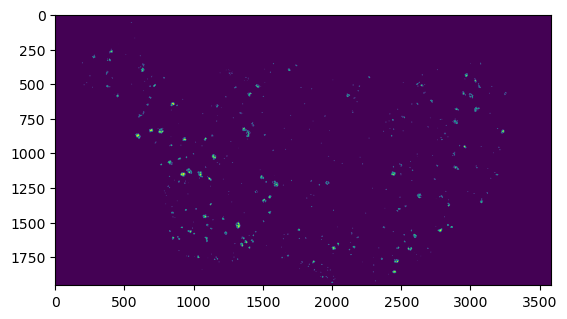

In [294]:
print(tissue_pixel_[7]) # number of pixels that compose Gamma PP cells in the sample
plt.imshow(rescaled[7]) # visualization of the alpha cells of the sample


Sample 2, Gamma PP autoco-occurrence. Similar happens to  Schwan cells

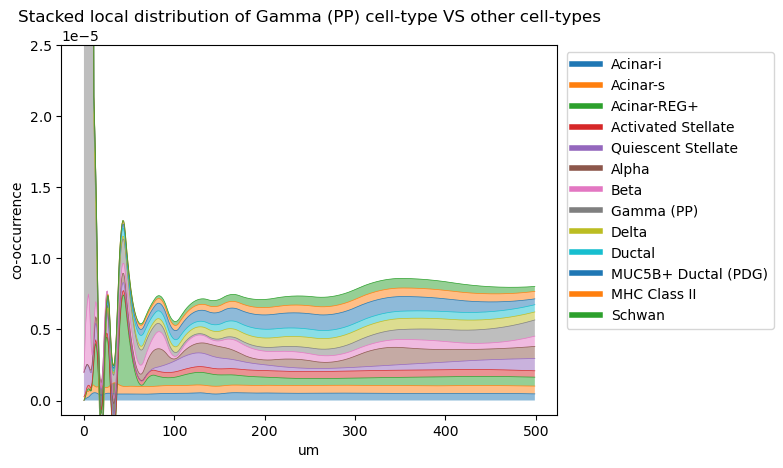

In [291]:
stacked_local_distrib(cooc_template_, 7, normal_array=tissue_pixel_)
# stacked_local_distrib(cooc_template_, 6)

131.0


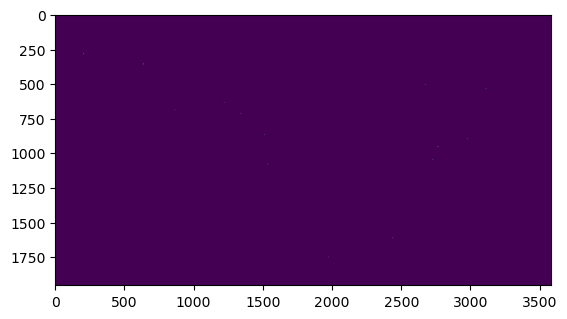

In [292]:
plt.imshow(rescaled[8])
print(tissue_pixel_[7])

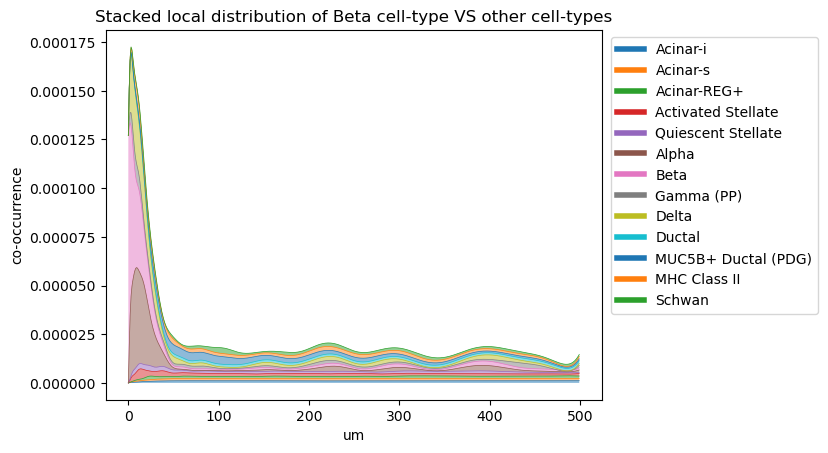

In [28]:
cooc_curves_res = cooc_template_
cell_type = 6
cell_type_labels = relevant_cluster_labels
um_per_px = 1.0



ct_list = list(range(0,13))
cell_type_sum = np.zeros(500)
    
fig, ax = plt.subplots()

ax.set_ylabel("co-occurrence")
ax.set_xlabel("um") 
ax.set_title(f"Stacked local distribution of {cell_type_labels[cell_type]} cell-type VS other cell-types")

 # plotting of other cell-types
for i in ct_list:
    Y = cooc_curves_res[cell_type,i]/tissue_pixel_[i]
    X = np.arange(len(Y))*um_per_px
    prev = cell_type_sum.copy()
    cell_type_sum += Y
    ax.fill_between(X,cell_type_sum,prev, alpha = 0.5)
    ax.plot(cell_type_sum, label=cell_type_labels[i], linewidth=0.5)

# get the legend object
leg = ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.show()

### Normalisation to the number of pixels

97550.0
984839.0
14495.0
4537.0
2790.0
7951.0
20647.0
1322.0
10936.0
32367.0
2125.0
7883.0
2347.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Acinar-i'),
  Text(1, 0, 'Acinar-s'),
  Text(2, 0, 'Acinar-REG+'),
  Text(3, 0, 'Activated Stellate'),
  Text(4, 0, 'Quiescent Stellate'),
  Text(5, 0, 'Alpha'),
  Text(6, 0, 'Beta'),
  Text(7, 0, 'Gamma (PP)'),
  Text(8, 0, 'Delta'),
  Text(9, 0, 'Ductal'),
  Text(10, 0, 'MUC5B+ Ductal (PDG)'),
  Text(11, 0, 'MHC Class II'),
  Text(12, 0, 'Schwan')])

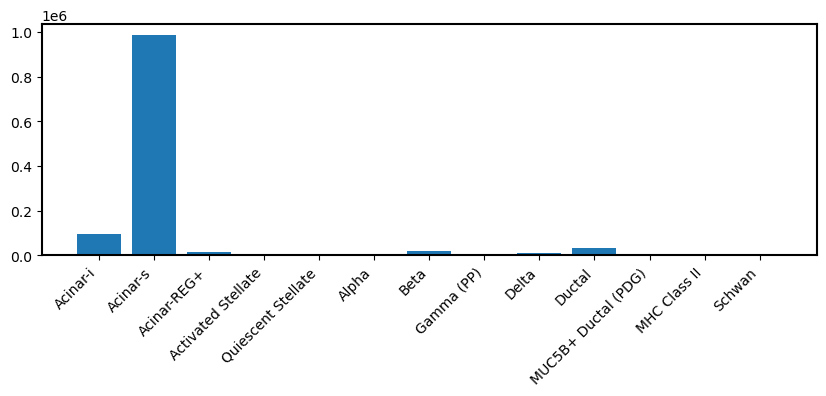

In [608]:
# calculation of the tissue area of each cell-type
plt.figure(figsize=[10,3])
tissue_pixels = []
for i in range(len(relevant_cluster_labels)):
    pix_agreg = np.sum(rescaled[i+1])
    tissue_pixels.append(pix_agreg)
    print(pix_agreg)

plt.bar(relevant_cluster_labels,tissue_pixels)
plt.xticks(rotation=45, ha="right")